# Reporte reto clasificación ML1

In this notebook we report  chance of heart attack using clasification models

In [ ]:
# Ejecutar esta celda solo desde google colab
!git clone https://github.com/alejoaj22/ml-tarea-competencia.git "/reto_ml_clasifica"

%cd /reto_ml_clasifica

In [4]:
import os
from functools import partial
import joblib
import pandas as pd
import data
import metrics
import seaborn as sns
from scipy import stats
import requests
import json

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Información de cada integrante del grupo de trabajo

**Nombre Completo:** ALEJANDRO JARAMILLO MIRA <br>
**Cédula:** 1152209579 <br>
**Correo Institucional:** alejandro.jaramillom@udea.edu.co <br><br>

**Nombre Completo:** CAROLINA GARCÍA PATIÑO <br>
**Cédula:** 1152438081 <br>
**Correo Institucional:** carolina.garcia5@udea.edu.co
<br><br>

**Nombre Completo:** JUAN PABLO GUTIÉRREZ MURIEL <br>
**Cédula:** 1214734406 <br>
**Correo Institucional:** juan.gutierrez36@udea.edu.co <br><br>


**Nombre Completo:** ROBIN ANDRES SOTO HINCAPIE<br>
**Cédula:** 1035428708<br>
**Correo Institucional:** robin.soto@udea.edu.co

In [5]:
def evaluate_model(*, model, metric, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_error = metric(y_train, train_predictions)
    test_error = metric(y_test, test_predictions)
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_error": train_error,
        "test_error": test_error
    }

def print_report(*, model, evaluation):
    print(f"Model used:\n\t{reg}")
    print(f"Error:\n\ttrain set {evaluation['train_error']}\n\ttest error: {evaluation['test_error']}")

In [7]:
models_dir = "models"

In [42]:
dataset_path = "train_classification.csv"

In [43]:
# Aquí ya se cargan los datos con las transformaciones que se explican más adelante.
dataset = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Analisis exploratorio de los datos

In [41]:
df_data= pd.read_csv(dataset_path, sep=',')

In [11]:
df_data.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,y
0,54,1,2,150,232,0,0,165,0,1.6,2,0,3,1
1,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1
2,47,1,0,112,204,0,1,143,0,0.1,2,0,2,1
3,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
4,58,1,0,100,234,0,1,156,0,0.1,2,1,3,0


In [189]:
dfff = pd.DataFrame({"age": df_data["age"],
                           "sex" : df_data["sex"],
                           "cp" : df_data["cp"],
                           "restecg" : df_data["restecg"],
                           "thalachh" : df_data["thalachh"],
                           "oldpeak" : df_data["oldpeak"],
                           "slp" : df_data["slp"],
                           "caa" : df_data["caa"],
                           "thall" : df_data["thall"], "y": df_data["y"]})

In [8]:
df_data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,y
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,54.650246,0.660099,1.009852,130.812808,248.448276,0.128079,0.527094,149.655172,0.330049,1.033005,1.403941,0.635468,2.330049,0.527094
std,9.019826,0.474846,1.043557,17.071615,55.012339,0.335004,0.529342,22.672426,0.471393,1.101908,0.616910,0.920139,0.600687,0.500500
min,34.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.500000,0.000000,0.000000,134.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,277.000000,0.000000,1.000000,166.500000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,195.000000,1.000000,5.600000,2.000000,3.000000,3.000000,1.000000


Haciendo una revisión general a los datos, notamos que no hay datos nulos en el dataset que haya que limpiar, además vemos que la edad promedio del dataset está al rango de los 54 años, osea que están en la edad en la cual se puede tener un paro cardio más probablemente según estudios, además de que según el promedio de la variable objetivo "y" hay más personas con probabilidades de ataques al corazón en el dataset.

In [33]:
df_data.shape

(203, 14)

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       203 non-null    int64  
 1   sex       203 non-null    int64  
 2   cp        203 non-null    int64  
 3   trtbps    203 non-null    int64  
 4   chol      203 non-null    int64  
 5   fbs       203 non-null    int64  
 6   restecg   203 non-null    int64  
 7   thalachh  203 non-null    int64  
 8   exng      203 non-null    int64  
 9   oldpeak   203 non-null    float64
 10  slp       203 non-null    int64  
 11  caa       203 non-null    int64  
 12  thall     203 non-null    int64  
 13  y         203 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 22.3 KB


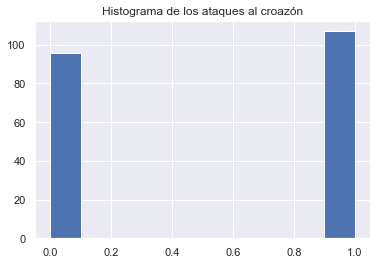

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

df_data.y.hist()
plt.title("Histograma de los ataques al croazón");

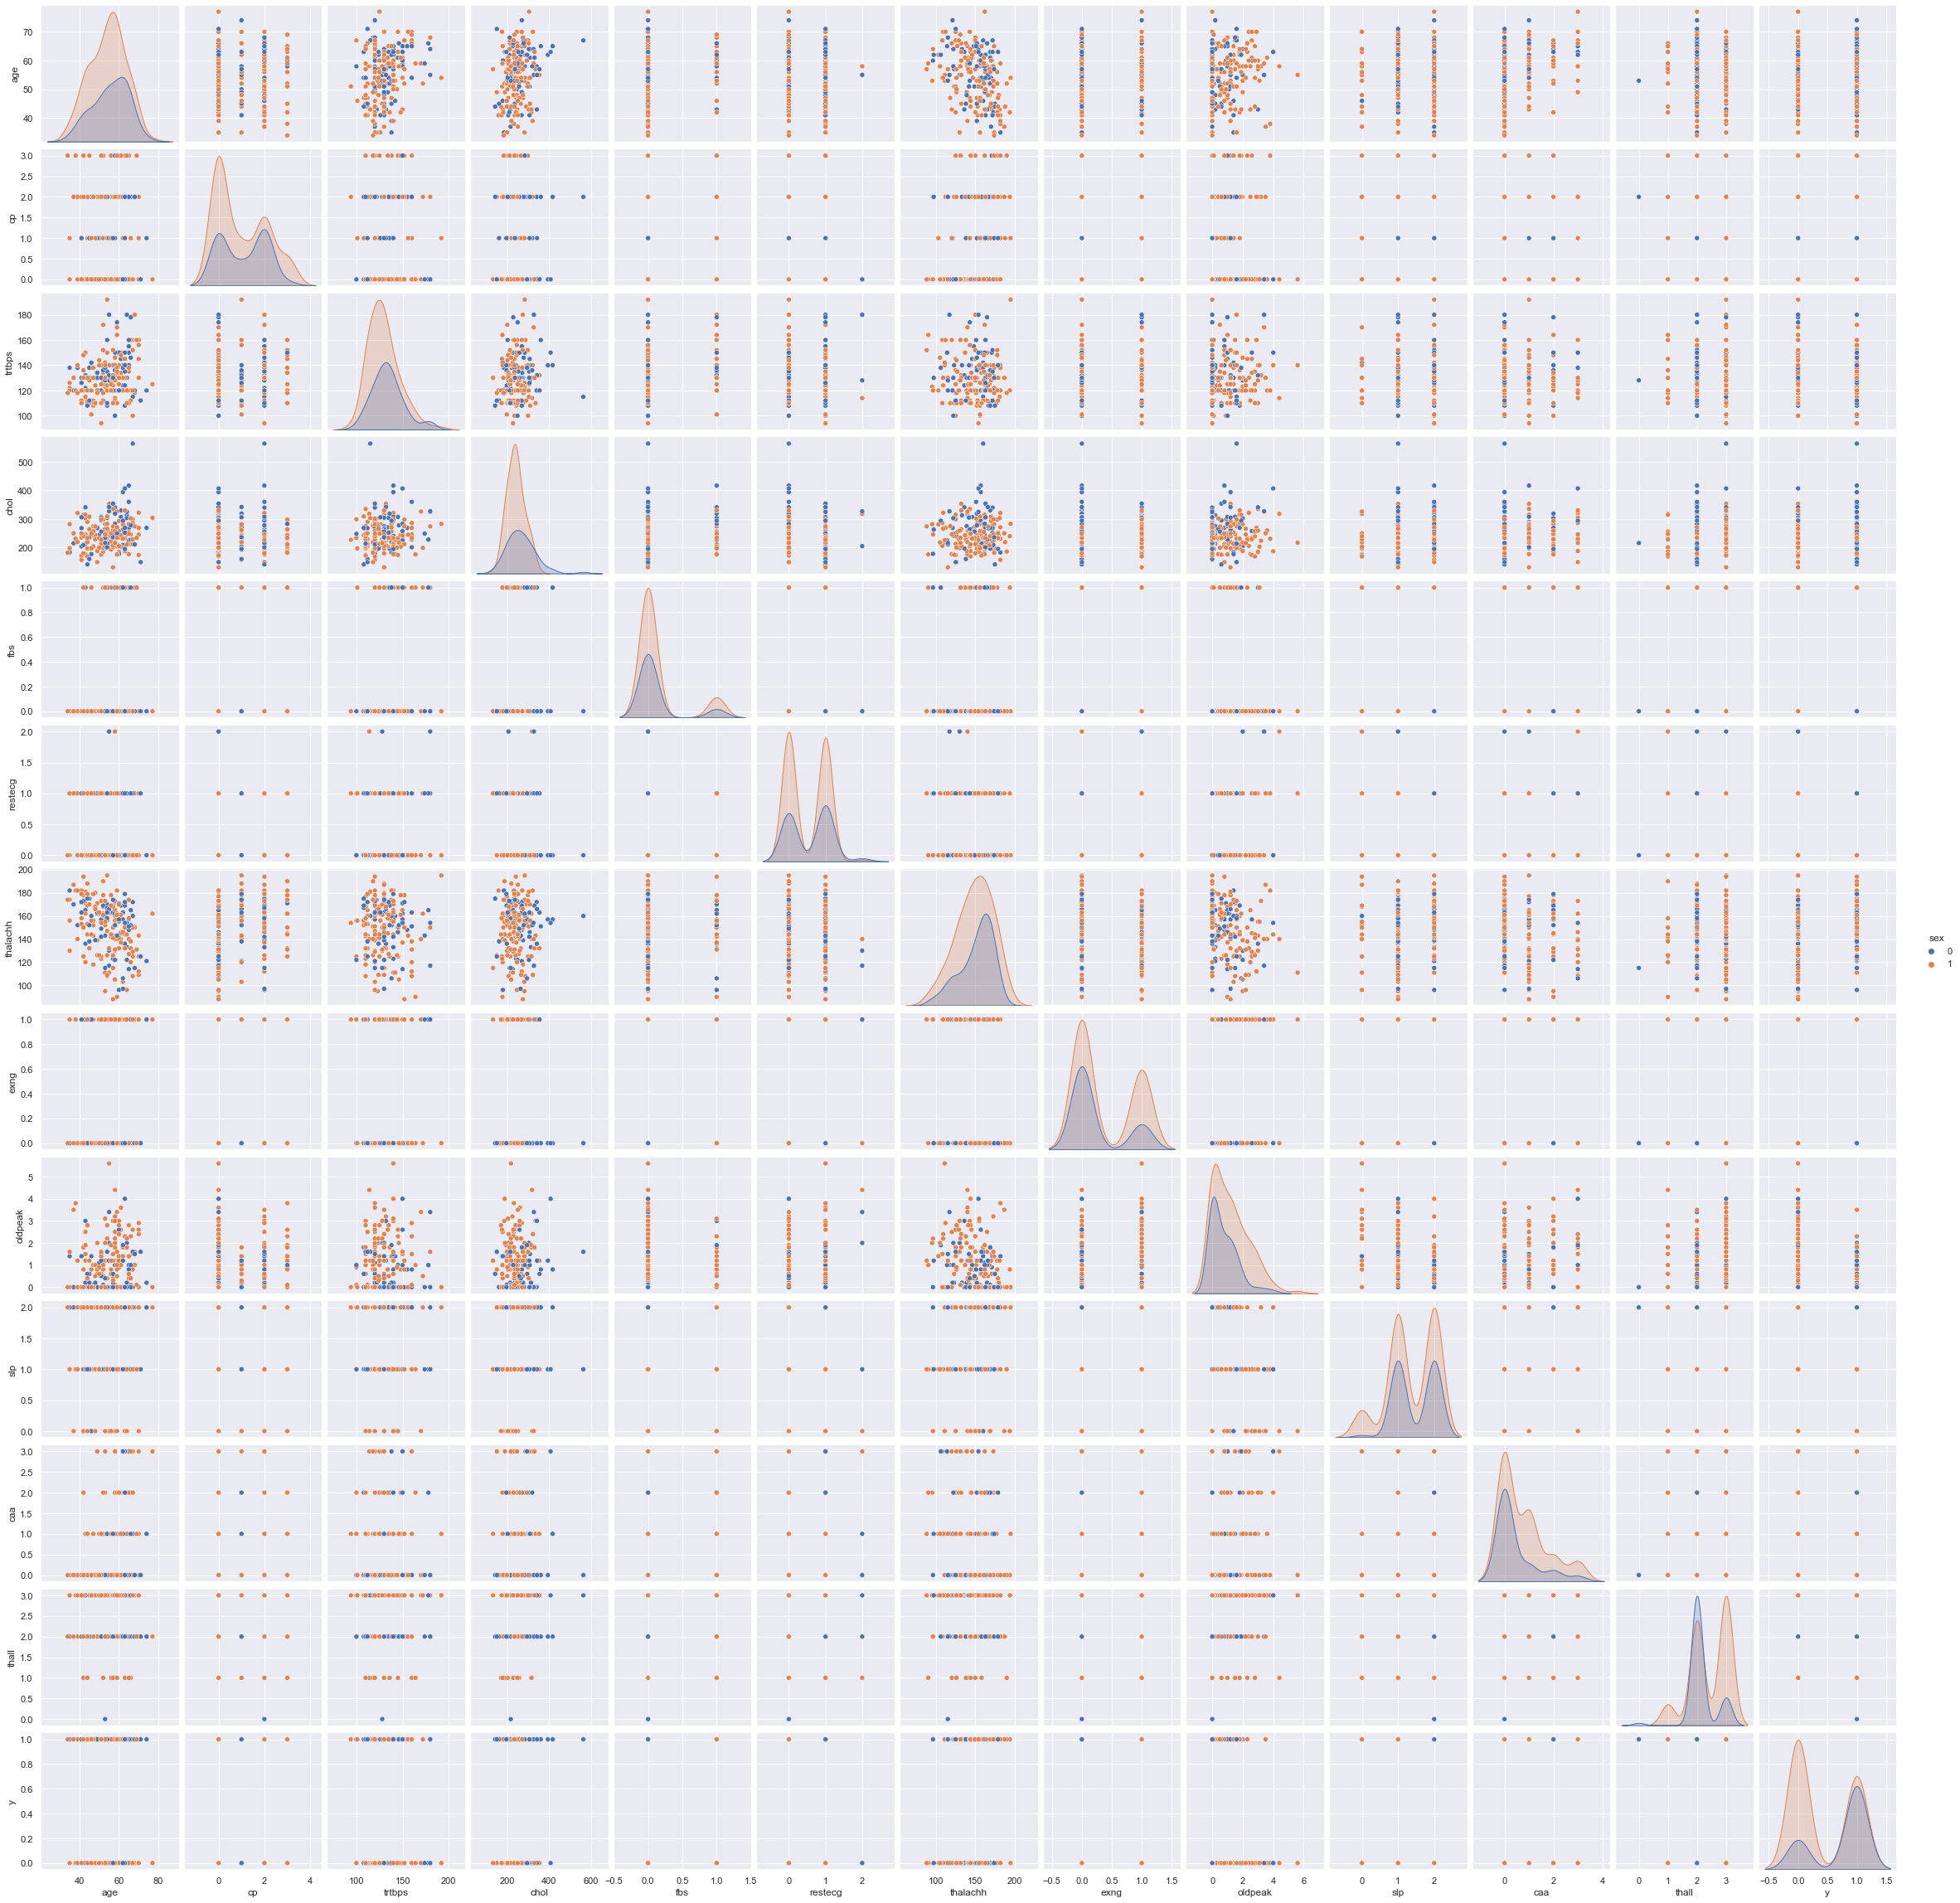

In [16]:
sns.pairplot(df_data, hue="sex");

# Limpiando el dataset

Lo que primero vamos hacer es analizar y eliminar los datos irregulares o "overline" que pueden afectar elresultado final de la predicción.

<AxesSubplot:xlabel='age'>

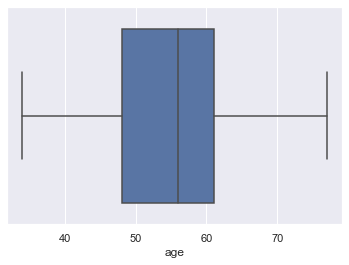

In [14]:
sns.boxplot(x=df_data['age'])


<AxesSubplot:xlabel='sex'>

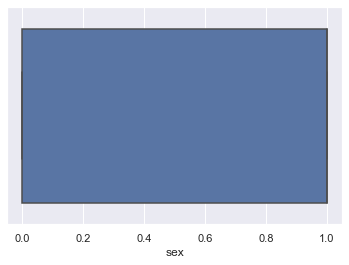

In [15]:
sns.boxplot(x=df_data['sex'])


<AxesSubplot:xlabel='cp'>

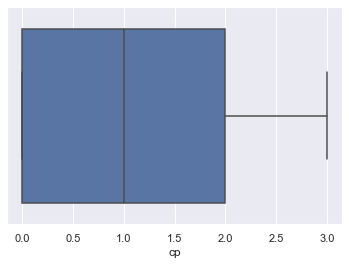

In [16]:
sns.boxplot(x=df_data['cp'])


<AxesSubplot:xlabel='trtbps'>

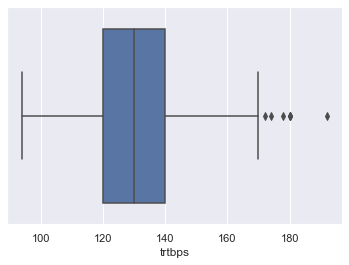

In [17]:
sns.boxplot(x=df_data['trtbps'])


<AxesSubplot:xlabel='chol'>

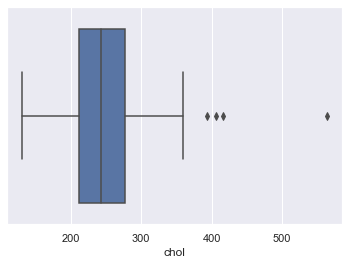

In [18]:
sns.boxplot(x=df_data['chol'])


<AxesSubplot:xlabel='fbs'>

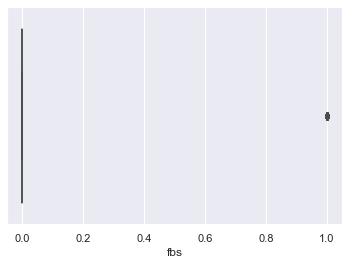

In [19]:
sns.boxplot(x=df_data['fbs'])


<AxesSubplot:xlabel='restecg'>

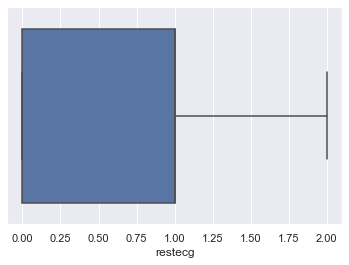

In [20]:
sns.boxplot(x=df_data['restecg'])


<AxesSubplot:xlabel='thalachh'>

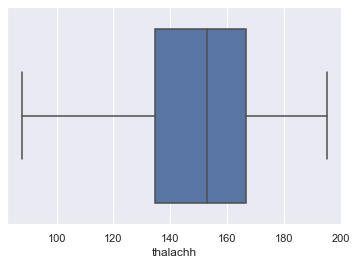

In [21]:
sns.boxplot(x=df_data['thalachh'])


<AxesSubplot:xlabel='exng'>

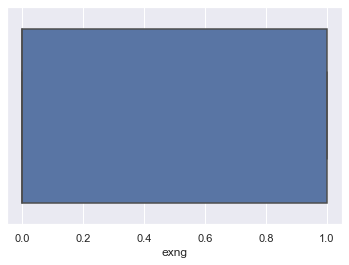

In [22]:
sns.boxplot(x=df_data['exng'])


<AxesSubplot:xlabel='oldpeak'>

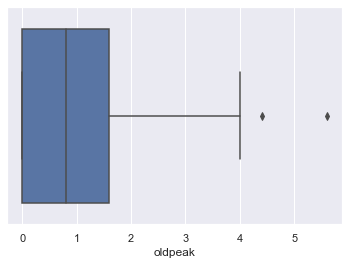

In [23]:
sns.boxplot(x=df_data['oldpeak'])


<AxesSubplot:xlabel='slp'>

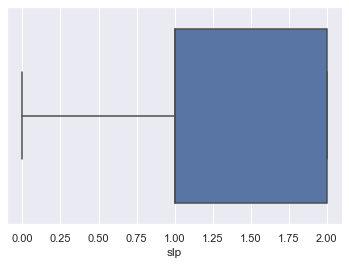

In [24]:
sns.boxplot(x=df_data['slp'])


<AxesSubplot:xlabel='caa'>

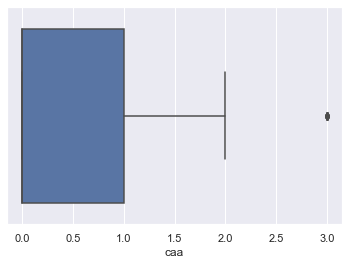

In [25]:
sns.boxplot(x=df_data['caa'])


<AxesSubplot:xlabel='thall'>

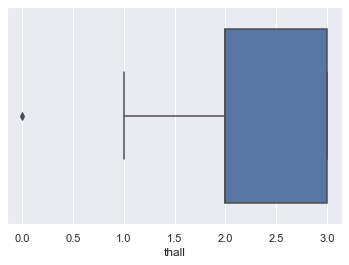

In [26]:
sns.boxplot(x=df_data['thall'])

De lo que encontramos en este analisis vemos que las columnas de trtbps, chol, thalachh, oldpeak, caa y thall tienen valores outliers , así que vamos a eliminarlos con un metodo a coninuación.

Eliminando los valores fuera de linea con z-core . investigando llegamos a esta metrica que nos ayuda a eliminar estos datos y además, quedamos con bastantes filas en el dataset para poder entrenar.

In [31]:

auxiliar = np.abs(stats.zscore(df_data))
df_data_3 = df_data[(auxiliar<3).all(axis=1)]
df_data_3.shape

(197, 14)

## Correlación

Para un mejor analisis de los datos, revisamos la correlación entre las variables y la salida

Text(0.5, 1.0, 'Pearson Correlation')

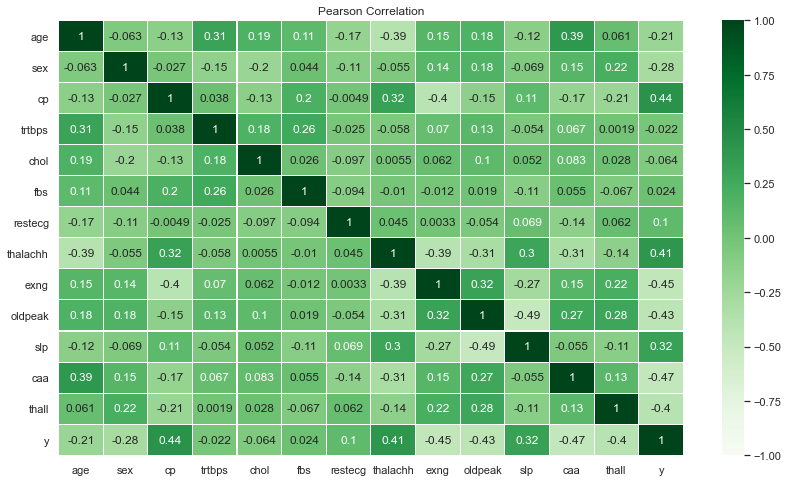

In [36]:
pearsonCorr = df_data_3.corr(method='pearson')
fig = plt.subplots(figsize=(14,8))
sns.heatmap(pearsonCorr, vmin=-1,vmax=1, cmap = "Greens", annot=True, linewidth=0.1)
plt.title("Pearson Correlation")

Del anterior gráfico concluimos que las columnas trtbps, chol, fbs son las columnas que tienen menor correlación con la variable de salida.

# Feature Engineering

Investigando un poco acerca de la probabilidad de ataque al corazón, luego de los 45 años crece la probabilidad de tener un ataque al corazón , así que vamos a agregar nuevas columans que ayuden mejor a la descripción del diagnostico y vamos agregar la edad como una variable categorica.
https://www.betterhealth.vic.gov.au/health/ConditionsAndTreatments/heart-disease-and-stroke-your-risk-score

También otro de los factores improtantes al momento de revisar el ataque al corazón es el colesterol alto, que en nuestro caso está representado por la variable chol https://www.healthline.com/health/heart-disease/warning-signs-heart-attack


Notas:
El dataset se encuentra bien balanceado a nivel de le la variable predicha




In [11]:
dataset["train"][0]['age'].unique()

array([52, 59, 63, 54, 51, 77, 61, 44, 45, 53, 50, 43, 62, 49, 42, 60, 58,
       48, 34, 70, 57, 56, 41, 69, 68, 47, 65, 66, 39, 35, 38, 71, 55, 64,
       46, 74, 67, 37])

Ceaciónd de los modelos y sus respectivos resultados

## RidgeClassifier
Con F1 score de prueba

In [51]:

#HAciendo un train sin espicificar los valores del random forest
model_path = os.path.join("models", "2021-06-20 16-45", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier', RandomForestClassifier())])
Error:
	train set 1.0
	test error: 0.8852459016393444


In [52]:
#modelo buscando parametros 

model_path = os.path.join("models", "2021-06-20 16-47", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features='sqrt'))])
Error:
	train set 0.9473684210526315
	test error: 0.8666666666666667


Con presicion score de prueba

In [53]:
#Usando los mejores parametros encontrados y modficando la profundidad a 4
model_path = os.path.join("models", "2021-06-20 16-49", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        max_features='sqrt'))])
Error:
	train set 0.9473684210526315
	test error: 0.9


In [54]:
#Usando los mejores parametros encontrados y modficando la profundidad a 3
#############################################################################
# Mejor resultado que obtuvimos
############################################################################
model_path = os.path.join("models", "2021-06-20 16-50", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        max_features='sqrt'))])
Error:
	train set 0.935064935064935
	test error: 0.9


In [55]:
#Usando los mejores parametros encontrados y modficando la profundidad a 2
model_path = os.path.join("models", "2021-06-20 16-51", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=2,
                                        max_features='sqrt'))])
Error:
	train set 0.8758169934640523
	test error: 0.8524590163934426


Intentando cambiar la metrica del error e intentado con los mejores parametros que encontramos antes

In [56]:
#Usando los mejores parametros encontrados y modficando la profundidad a 3
model_path = os.path.join("models", "2021-06-20 16-53", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.precision_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=2,
                                        max_features='sqrt'))])
Error:
	train set 0.8414634146341463
	test error: 0.8333333333333334


Clasificador Lineal (Base)

In [136]:
#Lineal sin hacer analisis exploratorio
model_path = os.path.join("models", "2021-06-20 17-55", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('lineal-classifier', RidgeClassifier())])
Error:
	train set 0.8789808917197452
	test error: 0.870967741935484


In [137]:
#Lineal haciendo busqueda por hyperparametros
model_path = os.path.join("models", "2021-06-20 17-57", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('lineal-classifier',
                 RidgeClassifier(alpha=0.1, fit_intercept=False, normalize=True,
                                 solver='lsqr', tol=0.1))])
Error:
	train set 0.8874172185430463
	test error: 0.8135593220338982


## Regresion logistica para la clasificación

In [138]:
model_path = os.path.join("models", "2021-06-20 16-43", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Logis-ticRegression',
                 LogisticRegression(random_state=0, solver='liblinear'))])
Error:
	train set 0.8758169934640523
	test error: 0.793103448275862


In [154]:
X_test_reto = pd.read_csv("test_classification_students_fix.csv", sep=",")
X_test_reto["y"]=0
X_test_reto.to_csv("test_classification_aux.csv",index=False)

In [155]:
X_test_reto.shape

(100, 14)

In [156]:
dataset_path_aux = "test_classification_aux.csv"

dataset_reto = data.get_dataset_mod(
    partial(pd.read_csv, filepath_or_buffer=dataset_path_aux),
    splits=("train", "test")
)

In [185]:
model_path = os.path.join("models", "2021-06-20 16-47", "model.joblib")
model_reto = joblib.load(model_path)

X_test_reto=dataset_reto["test"][0]

el mejor modelo hasta ahora para nosotros es el "2021-06-20 16-49" con un {"F1":0.864406779661017}'

In [186]:
test_predictions = model_reto.predict(X_test_reto)

In [187]:
URL = "https://qzbbjszmjk.execute-api.us-east-1.amazonaws.com/dev"

results = {"id": "ALEJANDRO JARAMILLO MIRA; CAROLINA GARCÍA PATIÑO; JUAN PABLO GUTIÉRREZ MURIEL; ROBIN ANDRES SOTO HINCAPIE","email": "alejandro.jaramillom@udea.edu.co", "task_type": "clasification" ,"predictions": test_predictions.tolist()}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

#Quitar comentaro para enviar modelo
r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)

In [188]:
r.text

'{"F1":0.8508914100486222}'

## Error analysis

In [23]:
import numpy as np

In [60]:
dataset_path = "train_classification.csv"

In [62]:
# Aquí ya se cargan los datos con las transformaciones que se explican más adelante.
dataset = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

In [64]:
model_path = os.path.join("models", "2021-06-20 16-50", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.f1_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('standard-scaler', StandardScaler()),
                ('Random-forest-classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        max_features='sqrt'))])
Error:
	train set 0.935064935064935
	test error: 0.9


D:\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn

In [65]:
X_test = dataset["test"][0].reset_index()
y_true = dataset["test"][1].reset_index()["y"]
y_pred = pd.Series(evaluation["test_predictions"], name="Prediction")

In [66]:
pred_data=X_test.join([y_true , y_pred])
pred_data["error"]=np.abs(pred_data["y"]-pred_data["Prediction"])

In [80]:
error_data = pred_data[pred_data["error"]==1]
error_data.sort_values(by=["restecg"], ascending=False)

,index,age,sex,cp,restecg,thalachh,exng,oldpeak,slp,caa,thall,age_range,chollog,y,Prediction,error
12,112,57,1,0,1,126,1,1,1,0,1,1,5.303305,1,0,1
33,197,59,1,0,1,161,0,0,1,0,3,1,5.455321,1,0,1
48,165,59,0,0,1,143,1,0,1,0,2,1,5.517453,0,1,1
0,36,58,1,1,0,160,0,1,1,0,2,1,5.648974,0,1,1
38,196,57,0,1,0,174,0,0,1,1,2,1,5.463832,0,1,1
50,74,53,1,0,0,111,1,0,2,0,3,1,5.420535,1,0,1


Al realizar una primera validación de los errores se identifica que la mitad de estos corresponde a un diagnostico de ataque al corazón erroneo, mientras que la otra mitad corresponde a casos dónde si se dió un ataque al corazón pero el modelo indicó que no. A partir de esto se plantean las siguientes hipótesis:

1) $H_{01}$: El modelo usado comete mas errores para edades superiores a 56 años

2) $H_{02}$: El modelo se equivoca mas clasificando un ataque para las mujeres que para los hombres

2) $H_{03}$: Los errores  más altos están asociados a los fumadores.

In [75]:
dataset["train"][0].describe()

,age,thalachh,oldpeak,chollog
count,137.000000,137.000000,137.000000,137.000000
mean,54.313869,151.277372,0.715328,5.471660
std,9.318508,22.349737,0.907071,0.195465
min,34.000000,88.000000,0.000000,4.948760
25%,47.000000,140.000000,0.000000,5.342334
50%,56.000000,156.000000,0.000000,5.476464
75%,61.000000,168.000000,1.000000,5.594711
max,77.000000,194.000000,3.000000,5.886104
